In [1]:
import tensorflow as tf
from PIL import Image 
import cv2
import os, pickle
import matplotlib.pyplot as plt
import numpy as np
import random
from keras.utils import to_categorical
import h5py
import datetime
import matplotlib.patches as patches
import pandas as pd 
%matplotlib inline 


Using TensorFlow backend.


In this Jupyter notebook, we will prepare data for the "regression model" which one output head will detect digits in the image, another - localize box coordinates which surround a number in the image. Also, we are going to prepare another dataset for digits length classification.

### 1 ) Generate SVHN dataset
For further data preparation we use data prepared at [Preprocess.ipynb](1__Preprocess.ipynb) Jupyter notebook.

In [2]:
# Read pickle files
def read_pickle_file(data):
    with open(data, 'rb') as f:
        data = pickle.load(f)
    return data

extra_data = read_pickle_file(os.path.join("SVHN","extra", 'extra.pickle'))
train_data = read_pickle_file(os.path.join("SVHN","train", 'train.pickle'))
test_data = read_pickle_file(os.path.join("SVHN","test", 'test.pickle'))


Changing images paths and append train and extra datasets:

In [3]:
# Set a new path of images.
def set_new_file_path(data,new_path):
    for i in range(len(data)):
        data[i]["filename"] = os.path.join(new_path, data[i]['filename']) 
    return data

extra_data = set_new_file_path(extra_data, os.path.join("SVHN","extra"))
train_data = set_new_file_path(train_data, os.path.join("SVHN","train"))
test_data = set_new_file_path(test_data, os.path.join("SVHN","test"))
    
train_data  = extra_data + train_data 
del extra_data

We want to model work on mobile phones which taken pictures that are usually high quality. In order to get better results, we will use 55% best quality images (with the longest hypotenuse length) in our dataset for model training.  <br>
Calculating the hypotenuse threshold:

In [4]:
def get_image_sizes(data):
    im_sizes = []; ind = []
    
    for i in range(len(data)):
        skip = False
        for j in range(len(data[i]["boxes"])):
            if data[i]["boxes"][j]["top"] < 0 or data[i]["boxes"][j]["left"] < 0:
                skip = True
        # Skip pictures which contains more that 3 digits, first digit is 0 and wrong boxes coordinate 
        if len(data[i]["boxes"]) > 3 or int(data[i]["boxes"][0]["label"] == 10) or skip:
            continue
        image = Image.open(data[i]['filename'])
        im_sizes.append(image.size)
        ind.append(i)
    return  np.array(im_sizes), ind

# Calculate image widths and heights; Get images indexes 
train_sizes, train_ind = get_image_sizes(train_data)
test_sizes, test_ind  = get_image_sizes(test_data)

# Filter data
train_data = np.array(train_data)[train_ind]
test_data = np.array(test_data)[test_ind]

# Calculate train and test data hypotenuse threshold
train_hypotenuse = np.round(np.sqrt(train_sizes[:,0] ** 2 + train_sizes[:,1] ** 2), 2)
test_hypotenuse = np.round(np.sqrt(test_sizes[:,0] ** 2 + test_sizes[:,1] ** 2), 2)
thres_hypotenuse = np.percentile(train_hypotenuse, 45)

print("We use images for training which hypotenuse is longer than ", thres_hypotenuse, ".", sep="")

We use images for training which hypotenuse is longer than 99.02.


Getting higher quality images:

In [5]:
train_data = train_data[np.where(train_hypotenuse > thres_hypotenuse)]
test_data = test_data[np.where( test_hypotenuse> thres_hypotenuse)]

Now, we will augment the SVHN data by scaling the original image and sliding a window trough it to making sure that the number is still visible within this window. This procedure takes three steps:

Firstly we calculate each image min and max scales ratios (original image scale ratio is equal 1, more scale ratio is bigger than more number box area in the generated image is bigger as well). </br>
Secondly, we randomly pick scale ratio in [min scale; max scale] interval and by it calculate new image height and width.<br>
Thirdly, we estimate all possible images, in which there is an original image number box area and randomly select one. Finally, we crop a randomly selected image from the original image, normalize and resize to 48x64 pixels.

We will augment data by repeating this procedure three times, in every procedure we generate different scale image with random number location in the image. Some nuances to determine min and max scales:

* Min scale ratio- We calculate min scale ratio that box area of number in a new image would be more than 30%. If the original images number box area is already bigger than 30% we set min scale to 1.1.
* Max scale ratio - we take a smaller of two calculated max ratios:
    * Edge max scale ratio. We calculate max scale ratio with which any number box edge wouldn't be bigger than relevant new images edge
    * Area max ratio. We calculate the max scale ratio with which the number box area ratio wouldn't be more than 85% new images edge. If the original images number box area is already bigger than 75%, we take that it for CNN training without any additional augmentation.

In [6]:
def get_box_coordinates_and_label(boxes, image_size):
    
    # Get digits bounding boxes and labels
    top = []; left = []; height = []; width = []; 
    label = np.array([10.0]*5); coordinates = np.zeros((5,4))
    for i in range(len(boxes)): 
        top.append(boxes[i]['top'])
        left.append(boxes[i]['left'])
        height.append(boxes[i]['height'])
        width.append(boxes[i]['width'])
        if boxes[i]["label"] == 10:
            label[i] = 0.0
        else:
            label[i] = boxes[i]["label"]
        coordinates[i] = [boxes[i]['top'], boxes[i]['top'] + boxes[i]['height'],
                         boxes[i]['left'], boxes[i]['left'] + boxes[i]['width']]
    box_top = np.amin(top)
    box_left = np.amin(left)
    box_bottom = np.amax(top) + height[np.argmax(top)] 
    box_right = np.amax(left) + width[np.argmax(left)] 
    box_width = box_right - box_left
    box_height = box_bottom - box_top
    
    # If box bottom or rigth corrdiantes is wrong then reassign them
    #box_bottom, box_height = correct_coordinate(box_bottom, box_height, image_size[1])
    #box_right, box_width = correct_coordinate(box_right, box_width, image_size[0])

    return box_top, box_left, box_bottom, box_right, box_width, box_height, label[:3], coordinates[:3]

def maximum_scale(image_size, box_height, box_width):
    "evaluate maximum scale that number box area wouldn't be bigger than relative new image edge"
    y_scale = image_size[1] / box_height 
    x_scale = image_size[0] / box_width  
    max_scale = min(x_scale, y_scale) + 0.01
    return max_scale

def get_area_ratio(image_size, box_height, box_width):
    box_area = box_height * box_width
    image_area = image_size[0] * image_size[1]
    return box_area / image_area

def minimum_scale(box_area, image_area, ratio, threshold):
    ''' if parameter threshold is bigger than number box area and image ratio than fucntion calculates
    in the calculates scale ratio (minimum) that box area of number in new image would be more than 
    parameter threshold else is set to 1.1 '''
    
    if ratio < threshold:
        min_scale = np.ceil( (image_area *threshold / box_area) ** 0.5 *10) /10 
    else:
        min_scale = 1.1
    return min_scale

def correct_coordinate(coordinate, length, threshold):
    "fix bad labeled number box coordinates"
    if coordinate >  threshold:
        length -= (coordinate - threshold)
        coordinate = threshold
    return coordinate, length

def maximum_scale_by_area(ratio, threshold):
    if ratio >= threshold:
        max_ratio = 1
    else:
        max_ratio = ( threshold/ ratio)**0.5 
    return max_ratio

def init_reps_and_scales(area_ratio, min_thresh, reps):
    if area_ratio > min_thresh:
        scales = [1]
        rep = reps-1
    else:
        scales = []
        rep = reps
    return rep, scales
    
def get_scales(box_width, box_height, image_size, reps, min_thresh, max_thresh,i):
    
    box_area = box_width * box_height
    image_area = image_size[0] * image_size[1]
    area_ratio =  box_area / image_area
    rep, scales = init_reps_and_scales(area_ratio, min_thresh, reps)

    # Get minimum and maximum scales
    min_scale = minimum_scale(box_area, image_area, area_ratio, min_thresh)
    max_scale = min(maximum_scale(image_size, box_height, box_width), 
                    maximum_scale_by_area(area_ratio, max_thresh))

    scales_list = list(np.arange(min_scale, max_scale, 0.05)) #for test data generation
    scales.extend(random.sample(scales_list, min(rep, len(scales_list))))
    scales = list(set(scales)) 
    return  scales  

def get_new_image_coordinates(scale, image_size, image_height, image_width, box_top, box_bottom, box_right, box_left,\
                              box_width, box_height):
    
    # Calculate new image (cropped from original image) width and height  
    crop_im_height = np.ceil(image_size[1] / scale) 
    crop_im_width = np.ceil(image_size[0] /  scale) 
                       
    # Calculate stride width and heigth which we need cut off from original image
    window_height = image_size[1] - crop_im_height 
    window_width = image_size[0] - crop_im_width 

    # Random select how many pixels cut off from top and bottom sides 
    height_top = int(min(window_height, box_top))
    height_bottom = int(min(window_height, image_size[1]- box_bottom))
    image_top = random.sample(range(int(window_height-height_bottom), int(height_top+1)), 1)[0]
    image_bottom = int(image_size[1] - (window_height -image_top))
    
    # Random select how many pixels cut off from left and rigth sides 
    width_left = int(min(window_width, box_left))
    width_right = int(min(window_width, image_size[0]- box_right))
    image_left = random.sample(range(int(window_width- width_right), int(width_left +1)), 1)[0]
    image_right = int(image_size[0]- (window_width - image_left) )    
    
    height_ratio = image_height /crop_im_height
    width_ratio =  image_width / crop_im_width
    
    return image_top, image_bottom, image_left, image_right, height_ratio, width_ratio

def getLenNumber(boxes):
    if len(boxes) < 4:
        return len(boxes)
    else: 
        return 4
    
def getReps(boxes):
    "get number of image augmention repetitions"
    switcher = {
        0: 0,
        1: 6,
        2: np.random.choice([1,2], p=[0.5, 0.5]),
        3: 1
    }  
    return switcher.get(boxes,5)

In [7]:
def generate_dataset(data, image_height, image_width, reps, min_thresh, max_thresh, norm = True, length_data = False):
    
    pixel_depth = 255.0  # Number of levels per pixel. 
    half_pixel_depth = pixel_depth / 2
    dataset = np.ndarray(shape=(len(data)*(reps), image_height, image_width, 3),
                         dtype=np.float32)
    coordinates = np.ndarray(shape=(len(data)*(reps), 6))
    labels = np.ndarray(shape=(len(data)*(reps), 3, 11))
    length_labels = np.ndarray(shape=(len(data)*(reps), 5)) 
    num_image = 0

    
    for i in range(len(data)):
    
        image = Image.open(data[i]['filename'])
        # Get bounding boxes coordinates
        box_top, box_left, box_bottom, box_right, box_width, box_height, label, \
                coord = get_box_coordinates_and_label(data[i]["boxes"], image.size) 
        if length_data:
            reps = getReps(len(data[i]["boxes"]))
        scales = get_scales(box_width, box_height, image.size, reps, min_thresh, max_thresh, i)
               
        for scale in scales:
                  
            try:
               image_top, image_bottom, image_left, image_right, height_ratio, width_ratio = \
                    get_new_image_coordinates(scale, image.size, image_height, image_width, box_top, \
                                              box_bottom, box_right, box_left, box_width, box_height)
                #crop new image from origanl photo
            except:
                continue
                
            new_image = np.array(image.crop((image_left, image_top, image_right, image_bottom)\
                                    ).resize([image_width, image_height]))
            
            if norm:
                new_image = (new_image - half_pixel_depth)/ pixel_depth
            
            dataset[num_image, :, :, :] =  new_image
            coordinates[num_image, :] = np.array([  np.floor((box_top - image_top) * height_ratio),    #top
                                                    np.floor((box_left - image_left) * width_ratio),   #left
                                                    np.ceil((box_bottom - box_top) * height_ratio),     #height
                                                    np.ceil((box_right - box_left) * width_ratio),      #width
                                                    np.ceil((box_bottom - image_top ) * height_ratio), #bottom
                                                    np.ceil((box_right - image_left ) * width_ratio),]) #right
            labels[num_image, :, :] =  to_categorical(label, num_classes=11)
            length_labels[num_image, :] = to_categorical(getLenNumber(data[i]["boxes"]), num_classes=5)
            num_image += 1
            
        coordinates = coordinates.clip(min = 0.0)

    return dataset[:num_image], labels[:num_image], coordinates[:num_image], length_labels[:num_image] 


In [8]:
def get_indexes(data_length, validate_size, is_test_ind = False, test_size = 0):

    ind = np.arange(data_length)
    validate_ind = np.random.choice(ind, validate_size, replace= False)
    train_ind = np.delete(ind, validate_ind)
    if not is_test_ind:
        return validate_ind, train_ind
    
    test_ind = np.random.choice(train_ind, test_size, replace= False)
    train_ind = np.setdiff1d(train_ind, test_ind)
    return test_ind, validate_ind, train_ind
        
        

In [9]:
%%time
val_ind, train_ind =  get_indexes(len(train_data), 10000)
print(len(val_ind), len(train_ind))
SVHN_train_data, SVHN_train_labels, SVHN_train_coordinates, SVHN_train_length = generate_dataset(train_data[train_ind], 48, 64, 4, 0.3, 0.9)
print("Generated...")
SVHN_validate_data, SVHN_validate_labels, SVHN_validate_coordinates, SVHN_validate_length = generate_dataset(train_data[val_ind], 48, 64, 1, 0.3,0.9)
print("Generated validate...")
SVHN_test_data, SVHN_test_labels, SVHN_test_coordinates, SVHN_test_length = generate_dataset(test_data, 48, 64, 1, 0.3, 0.9)

10000 110373
Generated...
Generated validate...
Wall time: 33min 5s


Shuffle train datasets.

In [10]:
%%time
idx = np.random.permutation(len(SVHN_train_data))
SVHN_train_labels  = SVHN_train_labels[idx]    
SVHN_train_coordinates = SVHN_train_coordinates[idx] 
SVHN_train_length = SVHN_train_length[idx]

Wall time: 697 ms


Save augmented datasets.

In [11]:
%%time
#save SVHN data
with h5py.File('D:/regression_1.hdf5', 'w') as f:
    f.create_dataset("validate", data= SVHN_validate_data, compression="gzip")
    f.create_dataset("validate labels", data= SVHN_validate_labels, compression="gzip")
    f.create_dataset("validate coordinates", data= SVHN_validate_coordinates, compression="gzip")
    f.create_dataset("validate length", data= SVHN_validate_length, compression="gzip")
    f.create_dataset("train labels", data= SVHN_train_labels, compression="gzip")
    f.create_dataset("train coordinates", data= SVHN_train_coordinates, compression="gzip")
    f.create_dataset("train length", data= SVHN_train_length, compression="gzip")
    f.create_dataset("test", data= SVHN_test_data, compression="gzip")
    f.create_dataset("test labels", data= SVHN_test_labels, compression="gzip")
    f.create_dataset("test coordinates", data= SVHN_test_coordinates, compression="gzip")
    f.create_dataset("test length", data= SVHN_test_length, compression="gzip")

Wall time: 18 s


In [12]:
%%time
ind_m = int(len(idx)/2)
dataset_name = "train"
data = SVHN_train_data[idx[:ind_m]]
with h5py.File('D:/regression_1.hdf5', 'a') as f:
    f.create_dataset(dataset_name, data= data, compression="gzip", maxshape=(None,48,64,3))
    
data = SVHN_train_data[idx[ind_m:]]
with h5py.File('D:/regression_1.hdf5', 'a') as f:
    f[dataset_name].resize((f[dataset_name].shape[0] + data.shape[0]), axis = 0)
    f[dataset_name][-data.shape[0]:] = data

Wall time: 12min 42s


### 2 ) Explore augmented SVHN dataset

Firstly, let's look number box area ratio mean in images at each dataset datasets:

In [13]:
areas = []
for i in range(len(test_data)):
    
        image = Image.open(test_data[i]['filename'])
        # Get bounding boxes coordinates
        box_top, box_left, box_bottom, box_right, box_width, box_height, label, \
                coord = get_box_coordinates_and_label(test_data[i]["boxes"], image.size) 
        areas.append(box_width * box_height / (image.size[0]*image.size[1]))
        

In [14]:
area = 64*48
test_area = (SVHN_test_coordinates[:,4])*(SVHN_test_coordinates[:,5])/area
validate_area = (SVHN_validate_coordinates[:,4])*(SVHN_validate_coordinates[:,5])/area
train_area = (SVHN_train_coordinates[:,4])*(SVHN_train_coordinates[:,5])/area

print("Train number area ratio : ", np.mean(train_area))
print("Validate number area ratio: ", np.mean(validate_area))
print("Test number area ratio: ", np.mean(test_area)) 

Train number area ratio :  0.7282855621467539
Validate number area ratio:  0.6716643995163413
Test number area ratio:  0.6825349899267106


Now let's look at box area ratio distributions:

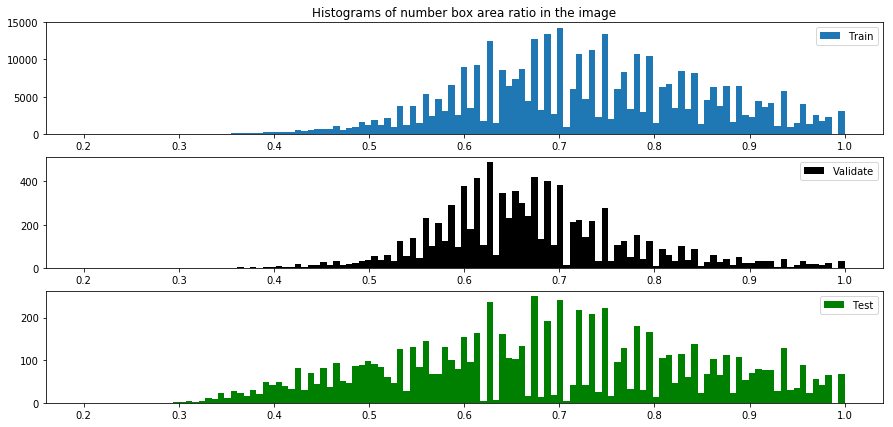

In [15]:
bins = np.linspace(0.2, 1, 120)

plt.figure(figsize=(15,7))
plt.subplot(3, 1, 1)
plt.hist(train_area, bins=bins, label = "Train") 

plt.title("Histograms of number box area ratio in the image")
plt.legend(loc='upper right')

plt.subplot(3, 1, 2)
plt.hist(validate_area, bins=bins, label = "Validate", color = "black")
plt.legend(loc='upper right')

plt.subplot(3, 1, 3)
plt.hist(test_area, bins=bins, label = "Test", color ="green")
plt.legend(loc='upper right')

plt.show()

Lastly, we going take a look how some generated images (not normalized) look like:

In [21]:
SVHN_data, SVHN_labels, SVHN_coordinates, _ = generate_dataset(train_data[4100:4300], 48, 64, 3, 0.3, 0.9, False)

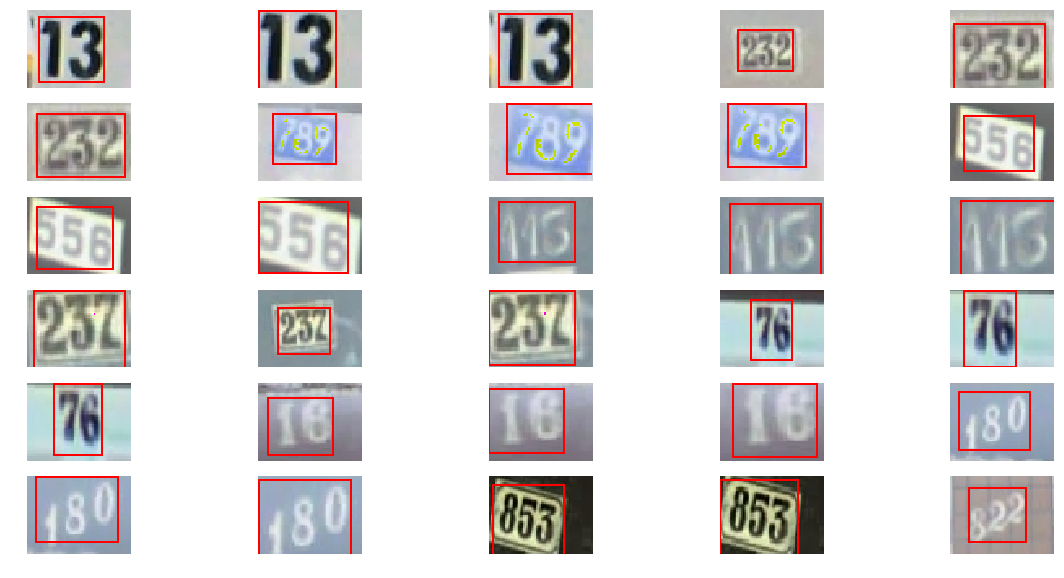

In [22]:
plt.rcParams['figure.figsize'] = (20.0, 10)
f, ax = plt.subplots(nrows=6, ncols=5)

for ind in range(30):
    j = ind % 5; i = int(np.floor(ind /5))
    ax[i][j].axis('off')
    ax[i][j].imshow(SVHN_data[ind])
    #ax[i][j].set_title(SVHN_labels[ind,1:])
    rect = patches.Rectangle((SVHN_coordinates[ind,1],SVHN_coordinates[ind,0]), SVHN_coordinates[ind,3],
                             SVHN_coordinates[ind,2], linewidth=2, edgecolor='r', facecolor='none')
    ax[i][j].add_patch(rect)

### 3 )  SVHN  +3 numbers dataset augmention
In this section, we augment SVHN numbers for CNN number length head training which classifies how many digits a number has in a given photo.

In [9]:
#Reading data
extra_data = read_pickle_file(os.path.join("SVHN","extra", 'extra.pickle'))
train_data = read_pickle_file(os.path.join("SVHN","train", 'train.pickle'))
test_data = read_pickle_file(os.path.join("SVHN","test", 'test.pickle'))

extra_data = set_new_file_path(extra_data, os.path.join("SVHN","extra"))
train_data = set_new_file_path(train_data, os.path.join("SVHN","train"))
test_data = set_new_file_path(test_data, os.path.join("SVHN","test"))

dataset  = extra_data + train_data + test_data

In [10]:
#Filtering data
def get_image_sizes_and_ind(data):
    im_sizes = []; ind = []
    
    for i in range(len(data)):
        skip = False
        for j in range(len(data[i]["boxes"])):
            if data[i]["boxes"][j]["top"] < 0 or data[i]["boxes"][j]["left"] < 0:
                skip = True
        # Skip pictures which contains more that 3 digits, first digit is 0 and wrong boxes coordinate 
        if int(data[i]["boxes"][0]["label"] == 10) or skip:
            continue
        image = Image.open(data[i]['filename'])
        im_sizes.append(image.size)
        ind.append(i)
    return  np.array(im_sizes), ind

# Calculate image widths and heights; Get images indexes 
dataset_sizes, dataset_ind = get_image_sizes_and_ind(dataset)
# Filter data
dataset = np.array(dataset)[dataset_ind]

dataset_hypotenuse = np.round(np.sqrt(dataset_sizes[:,0] ** 2 + dataset_sizes[:,1] ** 2), 2)
dataset = dataset[np.where( dataset_hypotenuse> thres_hypotenuse)]

In [11]:
#Set test, validation and train dataset lenghts
images_size = len(dataset)
validate_size = 8000
test_size = 4000
test_ind, val_ind, train_ind =  get_indexes(len(dataset), validate_size, True, test_size)

In [12]:
#Generating datasets
SVHN_train_data_4, _, __, SVHN_train_length_4 = generate_dataset(dataset[train_ind], 48, 64, 3, 0.2, 0.9, True, True)
print("Generated...")
SVHN_validate_data_4, _, __, SVHN_validate_length_4 = generate_dataset(dataset[val_ind], 48, 64, 3, 0.2,0.9, True, True)
print("Generated validate...")
SVHN_test_data_4, _, __, SVHN_test_length_4 = generate_dataset(dataset[test_ind], 48, 64, 3, 0.2, 0.9, True, True)

Generated...
Generated validate...


Digits distribution in generated SVHN images:  

In [13]:
pd.DataFrame([np.sum(SVHN_train_length_4, axis=0)/len(SVHN_train_length_4), 
                   np.sum(SVHN_validate_length_4, axis=0)/len(SVHN_validate_length_4),
                   np.sum(SVHN_test_length_4, axis=0)/len(SVHN_test_length_4)], 
                   columns=["0", "1", "2", "3", "4+"],
                   index = ["Train", "Validate", "Test"])

0         1         2         3        4+
Train     0.0  0.139527  0.342622  0.307993  0.209858
Validate  0.0  0.143575  0.334055  0.299281  0.223089
Test      0.0  0.147570  0.349641  0.314104  0.188685

### 3) Prepare 'not number' dataset 

Like mentioned in previous notebooks, we need that our number classification approach to regocnize if we aren't picturing a number. So, we add images which don't contain a number from [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), [Caltech 101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/)  and [Caltech 256](http://www.vision.caltech.edu/Image_Datasets/Caltech256/) datasets to the SVHN images.

Getting CIFAR images.

In [14]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [15]:
image_height, image_width = 48, 64
first_file = True
files = os.listdir("Cifar")
for file in files:
    data = unpickle(os.path.join("Cifar",file))
    if first_file:
        dataset = data[b"data"]
        first_file = False
    else:
        dataset = np.append(dataset, data[b"data"], axis = 0)
    
dataset = dataset.reshape((-1, 3,32,32))
dataset = np.swapaxes(dataset, 1, 2)
dataset = np.swapaxes(dataset, 2, 3)    
dataset = (dataset - 255.0/2) / 255.0

cifar_data = np.ndarray(shape=(len(dataset), image_height, image_width, 3),
                         dtype=np.float32)
cifar_labels = np.array([0]*5*len(dataset)).reshape((-1,5))

for i in range(len(dataset)):
    cifar_data[i,:,:,:] = cv2.resize(dataset[i], ( 64, 48))


Getting Caltech 101 and Caltech 256 images.

In [16]:
def get_files_paths(primary_folder):
    paths = []
    folders = os.listdir(primary_folder )
    for folder in folders:
        files = os.listdir(os.path.join(primary_folder, folder))
        for file in files:
            paths.append(os.path.join(primary_folder, folder, file))
    return paths

In [17]:
#Get files paths
obj256 = get_files_paths("256_ObjectCategories")
obj101 = get_files_paths("101_ObjectCategories")
paths = obj101 + obj256

In [18]:
def read_data(paths, image_width, image_height):
    
    pixel_depth = 255.0  # Number of levels per pixel. 
    half_pixel_depth = pixel_depth / 2
    dataset = np.ndarray(shape=(len(paths), image_height, image_width, 3),
                         dtype=np.float32)
    labels = np.ndarray(shape=(len(paths), 5))
    temp_label = [1,0,0,0,0]
    j = 0
    
    for i in range(len(paths)):
        try:
            image = cv2.imread(paths[i])
            dataset[i, :, :, :] = (cv2.resize(image, (image_width, image_height)) - \
                                        half_pixel_depth) / pixel_depth
            labels[i, :] = temp_label
            j += 1
        except:
            print(i)
            
    return dataset[:j], labels[:j]
         

In [19]:
%%time 
#5min
obj_data, obj_labels = read_data(paths, 64, 48)

13851
29888
Wall time: 1min 58s


Merging CIFAR, Caltech 101 and Caltech 256 dataset.

In [20]:
obj_data = np.append(obj_data, cifar_data, axis = 0)
obj_labels = np.append(obj_labels, cifar_labels, axis = 0)
del cifar_data, cifar_labels

In [21]:
def shuffle_data(data, labels):
    idx = np.random.permutation(len(data))
    data = data[idx]
    labels  = labels[idx]
    return data, labels

obj_data, obj_labels = shuffle_data(obj_data, obj_labels)

### 3) Appending 'length' SVHN and 'not number' datasets

Randomly selecting which 'not number' images will be appended to SVHN test, train and validate datasets.

In [22]:
total = len(SVHN_train_data_4)+len(SVHN_validate_data_4)+ len(SVHN_train_data_4)
test_obj_size = int(len(SVHN_test_data_4)/total * len(obj_data))
validate_obj_size = int(len(SVHN_validate_data_4)/total *  len(obj_data))
test_ind, val_ind, train_ind =  get_indexes(len(obj_data), validate_size, True, test_size)

Creating testing and validatation dataset and save into h2py file format.

In [23]:
def append_datasets(data1, data2, data1_labels, data2_labels):
    data = np.concatenate((data1, data2), axis = 0)
    data_labels = np.concatenate((data1_labels, data2_labels), axis = 0)
    data, data_labels = shuffle_data(data, data_labels)
    return data, data_labels

test_data, test_labels = append_datasets(SVHN_test_data_4, obj_data[test_ind],
                                        SVHN_test_length_4, obj_labels[test_ind])
validate_data, validate_labels = append_datasets( SVHN_validate_data_4, obj_data[val_ind],
                                        SVHN_validate_length_4, obj_labels[val_ind])
    

In [24]:
with h5py.File('D:/regression_2.hdf5', 'w') as f:
    f.create_dataset("test", data=test_data, compression="gzip")
    f.create_dataset("test labels", data=test_labels, compression="gzip")
    f.create_dataset("validate", data=validate_data, compression="gzip")
    f.create_dataset("validate labels", data=validate_labels, compression="gzip")
del test_data, test_labels, SVHN_test_data_4
del validate_data, validate_labels, SVHN_validate_data_4
obj_data = obj_data[train_ind] 
obj_labels = obj_labels[train_ind]

Creating training dataset and save into h2py file format.

In [25]:
train_length_labels = np.append(SVHN_train_length_4, obj_labels, axis = 0)

ind = np.random.permutation(len(train_length_labels))
train_length_labels  = train_length_labels[ind]

with h5py.File('D:/regression_2.hdf5', 'a') as f:
    f.create_dataset("train labels", data=train_length_labels, compression="gzip")

In [26]:
def create_dataset(indx, SVHN_data, obj_data, file_name, dataset_name, write = True):
    data = np.ndarray(shape=(len(indx), 48, 64, 3),
                         dtype=np.float32)
    train_size = len(SVHN_data)
    j = 0

    for i in indx:
    
        if i >= train_size:
            data[j] = obj_data[i-train_size]
        else:
            data[j] = SVHN_data[i]
        j += 1
    if write:
        with h5py.File(file_name, 'a') as f:
            f.create_dataset(dataset_name, data= data, compression="gzip", maxshape=(None,48,64,3))
    else: 
        with h5py.File(file_name, 'a') as f:
            f[dataset_name].resize((f[dataset_name].shape[0] + data.shape[0]), axis = 0)
            f[dataset_name][-data.shape[0]:] = data
            

In [27]:
%%time
ind_m = int(len(ind)/2)
print(datetime.datetime.now())
create_dataset(ind[:ind_m], SVHN_train_data_4, obj_data, "D:/regression_2.hdf5", "train data")
print(datetime.datetime.now())
create_dataset(ind[ind_m:], SVHN_train_data_4, obj_data, "D:/regression_2.hdf5", "train data", write = False)

2019-10-13 10:46:22.990296
2019-10-13 10:50:31.388671
Wall time: 8min 32s
